### Dependency installations

In [60]:
# If needed, install dependencies in current Jupyter kernel
# Source: http://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/
# import sys
# !{sys.executable} -m pip install kaggle==1.5.16

### Fetching and loading the data

In [61]:
import kaggle
import pandas as pd
from pathlib import Path

def fetch_load_kaggle_dataset(dataset):
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files(dataset, path='../datasets', unzip=True)
    return pd.read_csv(Path("../datasets/intermittent-renewables-production-france.csv"))

electricity_production_data = fetch_load_kaggle_dataset('henriupton/wind-solar-electricity-production')

### Checking the structure of the data

In [62]:
electricity_production_data.head()

,Date and Hour,Date,StartHour,EndHour,Source,Production,dayOfYear,dayName,monthName
0,2020-07-22 20:00:00+02:00,2020-07-22,20:00:00,21:00:00,Solar,244.0,204,Wednesday,July
1,2020-07-23 07:00:00+02:00,2020-07-23,07:00:00,08:00:00,Solar,223.0,205,Thursday,July
2,2020-07-23 16:00:00+02:00,2020-07-23,16:00:00,17:00:00,Solar,2517.0,205,Thursday,July
3,2020-07-23 19:00:00+02:00,2020-07-23,19:00:00,20:00:00,Solar,658.0,205,Thursday,July
4,2020-07-23 23:00:00+02:00,2020-07-23,23:00:00,24:00:00,Solar,0.0,205,Thursday,July


In [63]:
electricity_production_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59806 entries, 0 to 59805
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date and Hour  59806 non-null  object 
 1   Date           59806 non-null  object 
 2   StartHour      59806 non-null  object 
 3   EndHour        59806 non-null  object 
 4   Source         59806 non-null  object 
 5   Production     59804 non-null  float64
 6   dayOfYear      59806 non-null  int64  
 7   dayName        59806 non-null  object 
 8   monthName      59806 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 4.1+ MB


In [64]:
# Checking examples with missing values
electricity_production_data[electricity_production_data.isnull().any(axis=1)]

,Date and Hour,Date,StartHour,EndHour,Source,Production,dayOfYear,dayName,monthName
36164,2022-03-27 03:00:00+02:00,2022-03-27,02:00:00,03:00:00,Solar,NaN,86,Sunday,March
39321,2022-03-27 03:00:00+02:00,2022-03-27,02:00:00,03:00:00,Wind,NaN,86,Sunday,March


This data set seems to be complete without missing data, there are labels missing for two training examples (only 1 of which is for wind). So we will avoid imputing numeric data in the training set and trust that our dataset will always be complete but may have NaN values for the production label. Cyclical data is harder to impute as well, so for simplicity, we'll drop examples in our dataset with any missing variables.

In [65]:
electricity_production_data = electricity_production_data.dropna()
electricity_production_data[electricity_production_data.isnull().any(axis=1)]

,Date and Hour,Date,StartHour,EndHour,Source,Production,dayOfYear,dayName,monthName


In [66]:
electricity_production_data["dayName"].value_counts()

Wednesday    8592
Thursday     8592
Friday       8592
Saturday     8544
Monday       8496
Tuesday      8496
Sunday       8492
Name: dayName, dtype: int64

In [67]:
electricity_production_data["monthName"].value_counts()

January      5952
May          5952
April        5760
June         5760
February     5424
October      4466
July         4464
August       4464
December     4464
March        4458
September    4320
November     4320
Name: monthName, dtype: int64

In [68]:
electricity_production_data["Source"].value_counts()

Wind     29903
Solar    29901
Name: Source, dtype: int64

In [69]:
electricity_production_data.describe()

,Production,dayOfYear
count,59804.000000,59804.000000
mean,2792.859775,172.457612
std,3190.239316,104.938171
min,0.000000,1.000000
25%,42.000000,84.000000
50%,1871.000000,164.000000
75%,4053.250000,262.000000
max,17220.000000,366.000000


In [70]:
electricity_production_data[electricity_production_data["dayOfYear"] == 366]["Date"] # Dates of a leap year (2020)

6017     2020-12-31
6022     2020-12-31
6027     2020-12-31
6032     2020-12-31
6037     2020-12-31
6627     2020-12-31
6632     2020-12-31
6637     2020-12-31
6642     2020-12-31
6647     2020-12-31
6652     2020-12-31
6657     2020-12-31
10501    2020-12-31
10506    2020-12-31
10511    2020-12-31
10516    2020-12-31
11206    2020-12-31
11211    2020-12-31
11216    2020-12-31
11221    2020-12-31
11226    2020-12-31
14744    2020-12-31
14749    2020-12-31
14754    2020-12-31
14759    2020-12-31
14764    2020-12-31
14769    2020-12-31
14774    2020-12-31
15524    2020-12-31
15529    2020-12-31
15600    2020-12-31
15605    2020-12-31
15610    2020-12-31
16385    2020-12-31
16390    2020-12-31
16395    2020-12-31
16400    2020-12-31
16405    2020-12-31
16410    2020-12-31
16415    2020-12-31
16420    2020-12-31
18172    2020-12-31
18176    2020-12-31
18180    2020-12-31
18184    2020-12-31
18188    2020-12-31
18683    2020-12-31
18686    2020-12-31
Name: Date, dtype: object

In [71]:
import numpy as np
electricity_production_data["Source"].value_counts()

Wind     29903
Solar    29901
Name: Source, dtype: int64

In [72]:
# Let's just focus on wind for now - drop the 'Solar' rows from the dataset
drop_indexes = electricity_production_data[electricity_production_data["Source"] == "Solar"].index
electricity_production_data.drop(drop_indexes, inplace=True)

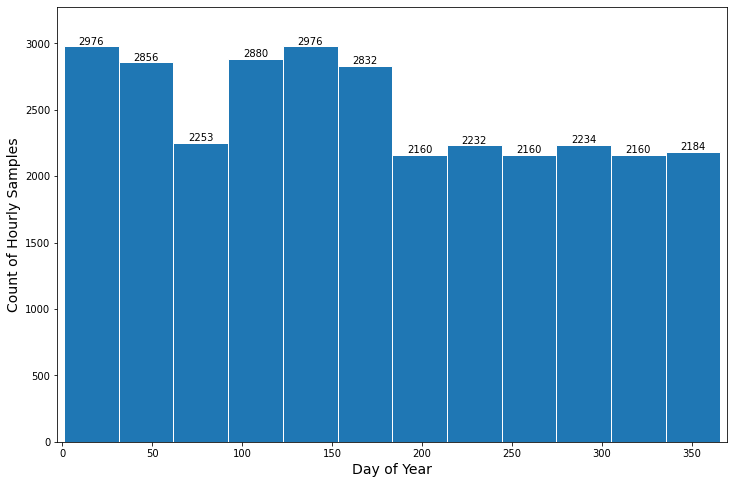

In [73]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

plt.figure(figsize=(12, 8))
values, bins, bars = plt.hist(electricity_production_data["dayOfYear"], bins=12, edgecolor='white')
plt.xlabel("Day of Year")
plt.ylabel("Count of Hourly Samples")
plt.bar_label(bars, fontsize=10)
plt.margins(x=.01, y=.1)

# approximate number of samples per month - use monthName field for exact

In [74]:
# observe examples with the highest output production
electricity_production_data.sort_values(by="Production", ascending=False)

,Date and Hour,Date,StartHour,EndHour,Source,Production,dayOfYear,dayName,monthName
52349,2023-02-26 15:00:00+01:00,2023-02-26,15:00:00,16:00:00,Wind,17220.0,57,Sunday,February
48142,2023-02-26 16:00:00+01:00,2023-02-26,16:00:00,17:00:00,Wind,17168.0,57,Sunday,February
54008,2023-03-10 10:00:00+01:00,2023-03-10,10:00:00,11:00:00,Wind,17168.0,69,Friday,March
56594,2023-04-01 00:00:00+02:00,2023-04-01,00:00:00,01:00:00,Wind,17093.0,91,Saturday,April
56057,2023-03-10 09:00:00+01:00,2023-03-10,09:00:00,10:00:00,Wind,17070.0,69,Friday,March
...,...,...,...,...,...,...,...,...,...
26659,2021-08-12 12:00:00+02:00,2021-08-12,12:00:00,13:00:00,Wind,52.0,224,Thursday,August
34900,2022-01-25 12:00:00+01:00,2022-01-25,12:00:00,13:00:00,Wind,51.0,25,Tuesday,January
33551,2022-01-25 13:00:00+01:00,2022-01-25,13:00:00,14:00:00,Wind,44.0,25,Tuesday,January
26657,2021-08-12 11:00:00+02:00,2021-08-12,11:00:00,12:00:00,Wind,43.0,224,Thursday,August


### Splitting the dataset using stratified sampling

In [75]:
from pandas import DataFrame
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(electricity_production_data, electricity_production_data["monthName"]):
    strat_train_set_n = electricity_production_data.iloc[train_index]
    strat_test_set_n = electricity_production_data.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

strat_train_set, strat_test_set = strat_splits[0]
# even shorter, a single stratified split
strat_train_set, strat_test_set = train_test_split(electricity_production_data, test_size=0.2, stratify=electricity_production_data["monthName"])

strat_test_set["monthName"].value_counts() / len(strat_test_set)

January      0.099482
May          0.099482
April        0.096305
June         0.096305
February     0.090787
August       0.074737
October      0.074737
July         0.074569
March        0.074569
December     0.074569
November     0.072229
September    0.072229
Name: monthName, dtype: float64

### Cleaning the data, combining attributes, dropping redundant features, encoding cyclical features, feature scaling and engineering

In [76]:
# Extract the labels
electricity_production_data = strat_train_set.drop("Production", axis=1)
electricity_production_data_labels = strat_train_set["Production"].copy()

There are a few things of note around the features of our dataset to consider during the data preprocessing steps:

Feature data types:
- There are a few categorical features (dayName, monthName, Source) that will need to be encoded.

Combining features:
- There are redundant features in this dataset (as in some features convey the same information), so we should look at combining some of these.

Cyclical nature of features:
- All of these features are also cyclical in nature (except for the Source feature), which needs to be conveyed to the model.
- The cyclical nature of our attributes needs to be preserved during encoding (e.g. using circular encoding / sine-cosine transformations to preserve cyclical patterns. One-hot encoding won't be suitable).`
- See the following guide on an approach for encoding cyclical features and some background reading: https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/

Dealing with the Source:
- We could drop the Source feature and retrain a single model for only Wind samples.
- We could also create an additional binary indicator that will allow the model to explicitly distinguish between the two sources of data.

We'll focus on the first option for simplicity, and to narrow the scope of any attributes that might come out of the feature engineering step to just wind power (for example, daylight hours are probably more useful for solar than wind).

Feature engineering:
- We may be able to derive additional features from the date and time information that might be meaningful & have an impact on energy production. Depending on what we choose, we might create a feature that can be very valuable for capturing temporal patterns in our dataset.

This could include daylight hours (for solar) or seasonal indicators. Something more useful might involve incorporating queries to an external weather data API to create binary indicators for weather conditions (rainy day vs non-rainy day, sunny vs cloudy, etc).

We will focus on just wind power predictions for this project for simplicity, and even though we only really care about predictive accuracy, we will also create a new attribute to represent the time of day (morning, afternoon, evening and night).
This may create redundancy is our features but will also help with interpretability ("Morning" is more intuitive for users than startHour being 7 or 8 for example) and reinforcing an assumption that the relationship between the time of day and
wind power production is actually non-linear (a categorical attribute will capture this non-linearity and help assist a linear model if it struggles to identify complex patterns in the data).

Data splitting:
- We have already split our data into training and testing (and later validation) sets. We should always make sure to do this prior to any data preprocessing.

Model selection and evaluation:
- Some models / algorithms are better suited to handling cyclical features and categorical data, so we should consider this when choosing which model to use.


With all that said, here's the plan:

**Date and Hour**: Dropping as redundant as we have 'StartHour' to represent time.
**Date**: Mostly redundant as we have 'dayOfYear' and 'monthName' to capture temporal information. Year will be extracted to capture seasonality or long term trends. Allows the model to capture potential impact of yearly variations on wind power.
**StartHour**: A cyclical feature representing the day cycle, which is relevant for capturing daily patterns. We have 24 distinct values.
**EndHour**: Dropping as redundant.
**Source**: Keeping only 'Wind' records to focus on wind power production.
**dayOfYear**: A cyclical feature representing the year cycle, which is relevant for capturing seasonal patterns.
**dayName**: Drop as unhelpful, as it may not capture significant patterns in your data.
**monthName**: A cyclical categorical feature, which is relevant for capturing monthly variations.
**Production**: Our target label, which we'll use for prediction.


In [77]:
# create a utility function we can use to encode cyclical attribute - TODO: consider refactoring into a CustomerTransformer
def encode_cat_cyc_attribute(df, attr):
    """
    Constructs 2 additional features on the data set by applying sin-cosine transformations for each unique value of the given dataframe's feature.
    formula:
    sin_attr = sin(2 * pi * attr / max(attr))
    cos_attr = cos(2 * pi * attr / max(attr))

    :param df: The DataFrame.
    :param attr: The attribute to encode.
    """

    vals = {}
    max_val = df[attr].max()
    for dist_val in df[attr].unique():
        vals[dist_val] = \
            (np.sin(2 * np.pi * dist_val / max_val),
            np.cos(2 * np.pi * dist_val / max_val))

    df[["sin_" + attr, "cos_" + attr]] = df[attr].apply(lambda v: pd.Series(vals[v]))

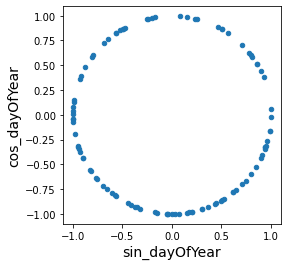

In [78]:
# encoding dayOfYear
encode_cat_cyc_attribute(electricity_production_data, "dayOfYear")
electricity_production_data.sample(100).plot.scatter("sin_dayOfYear","cos_dayOfYear").set_aspect("equal")

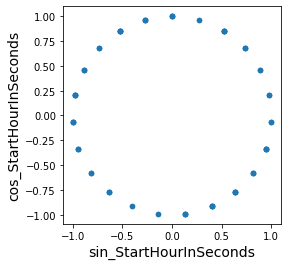

In [79]:
# encoding StartHour
electricity_production_data["StartHourInSeconds"] = pd.to_timedelta(electricity_production_data["StartHour"]).apply(lambda td: td.seconds)
encode_cat_cyc_attribute(electricity_production_data, "StartHourInSeconds")
electricity_production_data.sample(100).plot.scatter("sin_StartHourInSeconds","cos_StartHourInSeconds").set_aspect("equal")

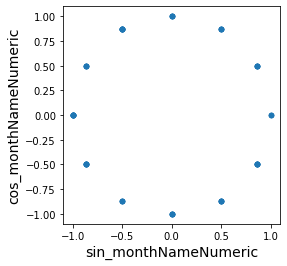

In [80]:
# encoding monthName
# label encode prior to cyclical encoding - we have to make some assumptions about the data here
months = ["January", "February", "March",
          "April", "May", "June",
          "July", "August", "September",
          "October", "November", "December"]
electricity_production_data["monthNameNumeric"] = electricity_production_data["monthName"].apply(lambda n: months.index(n) + 1)
encode_cat_cyc_attribute(electricity_production_data, "monthNameNumeric")
electricity_production_data.sample(100).plot.scatter("sin_monthNameNumeric","cos_monthNameNumeric").set_aspect("equal")

In [81]:
# encode Year
electricity_production_data["Year"] = pd.to_datetime(electricity_production_data["Date"]).apply(lambda dt: dt.year)

min_year = electricity_production_data["Year"].min()
electricity_production_data["YearPositional"] = electricity_production_data["Year"].apply(lambda y: y - min_year + 1)

In [82]:
# encode date as ordinal value in dataset
electricity_production_data["DateOrdinal"] = pd.to_datetime(electricity_production_data["Date"]).apply(lambda dt: dt.toordinal())
min_date = electricity_production_data["DateOrdinal"].min()
electricity_production_data["DateOrdinal"] = electricity_production_data["DateOrdinal"].apply(lambda do: do - min_date + 1)
electricity_production_data.head()

,Date and Hour,Date,StartHour,EndHour,Source,dayOfYear,dayName,monthName,sin_dayOfYear,cos_dayOfYear,StartHourInSeconds,sin_StartHourInSeconds,cos_StartHourInSeconds,monthNameNumeric,sin_monthNameNumeric,cos_monthNameNumeric,Year,YearPositional,DateOrdinal
39768,2022-04-10 04:00:00+02:00,2022-04-10,04:00:00,05:00:00,Wind,100,Sunday,April,0.989372,-0.145404,14400,0.887885,0.460065,4,0.866025,-5.000000e-01,2022,3,831
8582,2021-02-15 06:00:00+01:00,2021-02-15,06:00:00,07:00:00,Wind,46,Monday,February,0.710135,0.704066,21600,0.997669,-0.068242,2,0.866025,5.000000e-01,2021,2,412
28444,2021-09-13 17:00:00+02:00,2021-09-13,17:00:00,18:00:00,Wind,256,Monday,September,-0.949990,-0.312281,61200,-0.997669,-0.068242,9,-1.000000,-1.836970e-16,2021,2,622
16880,2021-01-16 17:00:00+01:00,2021-01-16,17:00:00,18:00:00,Wind,16,Saturday,January,0.271234,0.962513,61200,-0.997669,-0.068242,1,0.500000,8.660254e-01,2021,2,382
51424,2022-11-22 08:00:00+01:00,2022-11-22,08:00:00,09:00:00,Wind,326,Tuesday,November,-0.633978,0.773351,28800,0.816970,-0.576680,11,-0.500000,8.660254e-01,2022,3,1057


In [83]:
# drop features after finished with attribute encoding
electricity_production_data: DataFrame = electricity_production_data.drop(columns=["Date and Hour", "Date", "EndHour", "dayName", "dayOfYear", "StartHour", "StartHourInSeconds", "monthName", "monthNameNumeric", "Source", "Year"])
electricity_production_data.head()

,sin_dayOfYear,cos_dayOfYear,sin_StartHourInSeconds,cos_StartHourInSeconds,sin_monthNameNumeric,cos_monthNameNumeric,YearPositional,DateOrdinal
39768,0.989372,-0.145404,0.887885,0.460065,0.866025,-5.000000e-01,3,831
8582,0.710135,0.704066,0.997669,-0.068242,0.866025,5.000000e-01,2,412
28444,-0.949990,-0.312281,-0.997669,-0.068242,-1.000000,-1.836970e-16,2,622
16880,0.271234,0.962513,-0.997669,-0.068242,0.500000,8.660254e-01,2,382
51424,-0.633978,0.773351,0.816970,-0.576680,-0.500000,8.660254e-01,3,1057


Now that we've encoded our cyclical features, we can think about normalizing the other features the other features YearPositional and DateOrdinal to fit into a similar scale, otherwise the model might choose to attribute more meaning to the DateOrdinal than other features when making predictions on production levels. The strategy will be:

**YearPositional**: Standard (Z-score) Scaling - we will try this only if it causes problems for the model
**DateOrdinal**: Min-Max Scaling

Note that we're just illustrating the process here. Later when we create a transformation pipeline, we will apply the scalars to specific columns.

array([[<AxesSubplot:title={'center':'YearPositionalScaled'}>]],
      dtype=object)

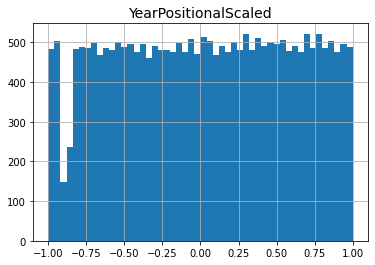

In [84]:
# Min max and standard scalers
from sklearn.preprocessing import MinMaxScaler, StandardScaler

std_scalar = StandardScaler()
min_max_scalar = MinMaxScaler(feature_range=(-1, 1))
year_positional_scaled = std_scalar.fit_transform(electricity_production_data[["YearPositional"]])
date_ordinal_scaled = min_max_scalar.fit_transform(electricity_production_data[["DateOrdinal"]])
pd.DataFrame(date_ordinal_scaled, columns=["YearPositionalScaled"]).hist(bins=50) # same uniform distribution, but value range exists between -1 and 1

Create a custom transformer that uses an estimator in its implementation. This transformer will use a KMeans clusterer in the fit method to identify clusters in the training data, and then rbf_kernel in the transform method to measure each sample's similarity to each cluster. This may allow us to discover patterns or grouping in the data relating to the relationship between the time of year and the production levels (e.g. maybe it's generally windier in March).

If we use the electricity_production_data_labels as sample weights when fitting a K-Means clustering model, it would give more weight to samples with higher output production levels. This means that during the clustering process, the cluster centers (centroids) would be influenced more by samples with higher production levels. As a result, cluster centers are more likely to be closer to samples with higher production levels because those samples have a greater influence due to their higher weights. This can be useful if you want the clusters to be more representative of regions or time periods with higher energy production.

KMeans is a clustering shallow algorithm.

In [85]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans

class ClusterSimilarityMeasure(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=5, gamma=1.0, random_state=42):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [86]:
# identify clusters, weight each sample by its output production level, and calculate the Gaussian RBF similarity measure between each sample and all clusters. Here K is 3...

cluster_simil = ClusterSimilarityMeasure(n_clusters=3)
similarities = cluster_simil.fit_transform(electricity_production_data[["sin_dayOfYear", "cos_dayOfYear"]], sample_weight=np.exp(electricity_production_data_labels * 0.03))
cluster_simil.kmeans_.cluster_centers_

array([[0.84460042, 0.53021557],
       [0.99996316, 0.00858348],
       [0.23885498, 0.97104412]])

We'll attach these similarity measures as features of our training set during initialisation of our transformation pipeline ColumnTransformer.

### Measuring attribute correlations

In order to compute the standard correlation coefficient between every pair of attributes and output production values, we needed to first encode our categorical & cyclical data.

In [87]:
corr_matrix = pd.concat([electricity_production_data, electricity_production_data_labels], axis=1).corr() # generate attribute correlation matrix
corr_matrix["Production"].sort_values(ascending=False)

Production                1.000000
cos_dayOfYear             0.364874
cos_monthNameNumeric      0.311339
sin_monthNameNumeric      0.235744
sin_dayOfYear             0.144497
YearPositional            0.096932
DateOrdinal               0.064331
cos_StartHourInSeconds    0.062468
sin_StartHourInSeconds   -0.037568
Name: Production, dtype: float64

**cos_dayOfYear and cos_monthNameNumeric**: These two features show the highest positive correlation with wind power production. This suggests that there might be seasonal and monthly patterns in wind power production, and these features capture some of those patterns.

**sin_monthNameNumeric and sin_dayOfYear**: Both sine-transformed features also show positive correlations with production, though slightly weaker. This reinforces the idea that cyclical patterns in the month and day of the year have an influence on wind power production.

**YearPositional**: This feature has a positive correlation with production, indicating that there might be some year-to-year variations that influence wind power production. However, the correlation is weaker compared to the cyclical features.

**cos_StartHourInSeconds and sin_StartHourInSeconds**: These features represent the cyclical nature of the start hour of the day and show some correlation with production. However, their correlations are relatively weaker, with cos_StartHourInSeconds having a positive correlation and sin_StartHourInSeconds having a negative correlation.

**DateOrdinal**: The DateOrdinal feature, which represents the date as an ordinal value, also shows a positive correlation (0.061774) with production, suggesting that there may be some temporal patterns influencing wind power production.


While correlation analysis provides valuable insights, it doesn't imply causation. We can further investigate these relationships and use them as informative features when building a predictive model.
To do this, we can use feature selection techniques and model evaluation to determine the most influential features.

We'll see the importance of samples similarity to our found clusters later when evaluating the feature importance after fitting our model. 

### Data visualisation

Display polar plots of sine and cosine transformed features against the Production target variable.

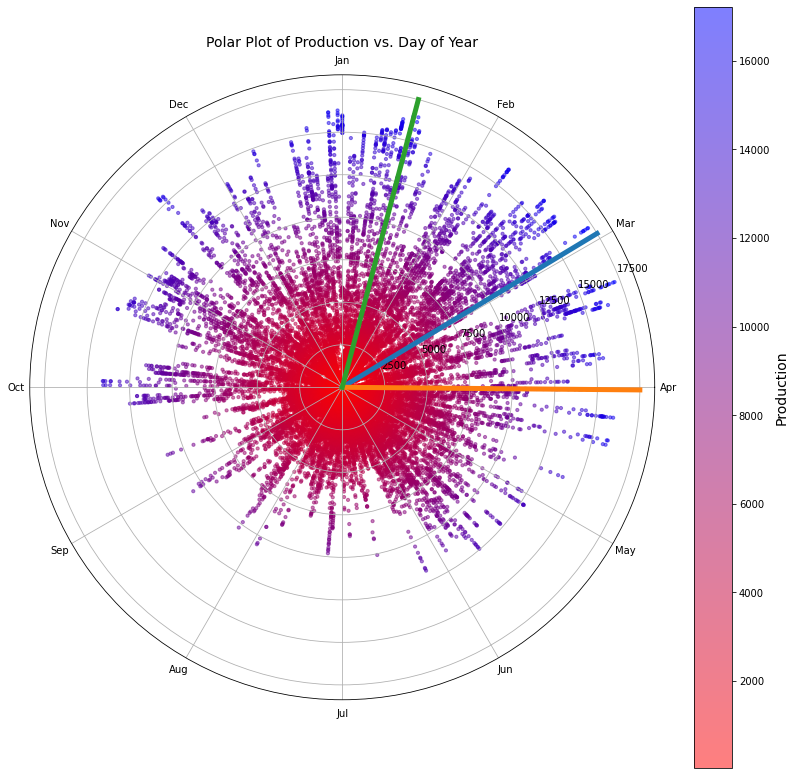

In [88]:
from matplotlib.colors import LinearSegmentedColormap

# calculate the angle (theta) based on sine and cosine values
sin_vals = electricity_production_data["sin_dayOfYear"]
cos_vals = electricity_production_data["cos_dayOfYear"]
theta = -np.arctan2(sin_vals, cos_vals) + np.pi / 2 # invert the angle and shift starting point to the top of the plot at the 12 o'clock position.

# offset all samples slightly by one degree clockwise
theta -= np.deg2rad(1)

# create a custom colormap transitioning from red to blue
cmap = LinearSegmentedColormap.from_list("RedToBlue", ["red", "blue"])

# create a polar plot
plt.figure(figsize=(14, 14))
ax = plt.subplot(111, projection="polar")

# plot production as the distance from the centre
sc = ax.scatter(
    theta,
    electricity_production_data_labels,
    marker="o",
    alpha=.5,
    s=10,
    c=electricity_production_data_labels,
    cmap=cmap
)

# define the labels for the months
month_labels = ['Dec', 'Nov', 'Oct', 'Sep', 'Aug', 'Jul', 'Jun', 'May', 'Apr', 'Mar', 'Feb', 'Jan']

# calculate positions for the month labels (12 equally spaced angles)
label_positions = np.linspace(0, 2 * np.pi, 12, endpoint=False)
label_positions = np.roll(label_positions, shift=-4)

# set the labels for the edges of the plot
ax.set_xticks(label_positions)
ax.set_xticklabels(month_labels)

# set title and labels
plt.title("Polar Plot of Production vs. Day of Year", va="bottom")

# Add a colorbar to show the mapping
cbar = plt.colorbar(sc)
cbar.set_label("Production")

# plot cluster centroids
cluster_centers = cluster_simil.kmeans_.cluster_centers_
cluster_sin_vals = cluster_centers[:, 0]
cluster_cos_vals = cluster_centers[:, 1]
cluster_theta = -np.arctan2(cluster_sin_vals, cluster_cos_vals) + np.pi / 2
cluster_theta -= np.deg2rad(1)
for angle in cluster_theta:
    ax.plot([0, angle], [0, 17500], linewidth=5)

# show the plot
plt.show()

### Conclusion for this notebook

we exponentially scaled the weights such that the clustering algorithm (kmeans) would tend to give more weight to periods of much higher output production. Initially the clusters didn't form in a way that was expected looking at the data, but giving the samples these exponential weights has moved the clusters to the periods within the year that look to have the highest production.

The weights of the samples weren't drastically different enough to have much influence on the algorithm and so that's why clusters tended to space themselves out evenly throughout the year (because it's looking at the count of samples - which is pretty evenly spaced - i.e. there are no periods of the year with much greater or lower number of samples).

By exponentially scaling the sample weights, we've effectively increased the influence of samples with much higher output production values on the clustering algorithm. This adjustment has allowed the algorithm to better capture and identify clusters in periods of the year with higher production, which aligns with our intuition about the data.

This has emphasized the importance of the high-production periods, which has led to more meaningful clusters in the data. It's a clever approach to enhance the clustering results when you have imbalanced data or when certain patterns in your data are more important than others.